In [5]:
import sys
sys.path.append('..')

import argparse
import logging
import math
import os
import random
import webdataset as wds
from pathlib import Path
from copy import deepcopy
import pandas as pd
import numpy as np
from PIL import Image

from pyproj import Geod
from shapely.geometry import shape as shapey
from shapely.wkt import loads as shape_loads

import torch
from torchvision import transforms

from diffusionsat import (
    SatUNet, DiffusionSatPipeline,
    SampleEqually,
    fmow_tokenize_caption, fmow_numerical_metadata,
    spacenet_tokenize_caption, spacenet_numerical_metadata,
    satlas_tokenize_caption, satlas_numerical_metadata,
    combine_text_and_metadata, metadata_normalize,
)

In [6]:
# cache location
os.environ["HF_HOME"] = "path/to/.cache/"

# Change caption/metadata here

In [7]:
caption = "a fmow satellite image of a amusement park in Australia"
# Normalized metadata: [longitude, latitude, gsd, cloud cover, year, month, day]
metadata = [ 925.8798,  345.2111, 411.4541,    0.0000,  308.3333,  166.6667, 354.8387]

# Or provide metadata values and then normalize
caption = "a fmow satellite image of a electric substation in India"
metadata = metadata_normalize([76.5712666476, 28.6965307997, 0.929417550564, 0.0765712666476, 2015, 2, 27]).tolist()

# Pipe 1: No finetuning

In [8]:
unet1 = SatUNet.from_pretrained("stabilityai/stable-diffusion-2-1", subfolder="unet", use_metadata=False, torch_dtype=torch.float16)
pipe1 = DiffusionSatPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", unet=unet1, torch_dtype=torch.float16)
pipe1 = pipe1.to("cuda")

vae\diffusion_pytorch_model.safetensors not found


#### Prompt pipe 1

e:\grade_three_two\deep-learning1\GISLab-Short-Term-Course\projects\DiffusionSat-Sakura\notebooks\..\diffusionsat\pipeline.py:594: FutureWarning: Accessing config attribute `in_channels` directly via 'SatUNet' object attribute is deprecated. Please access 'in_channels' over 'SatUNet's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

E:\grade_three_two\deep-learning1\GISLab-Short-Term-Course\projects\DiffusionSat-Sakura\src\diffusers\models\attention_processor.py:744: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


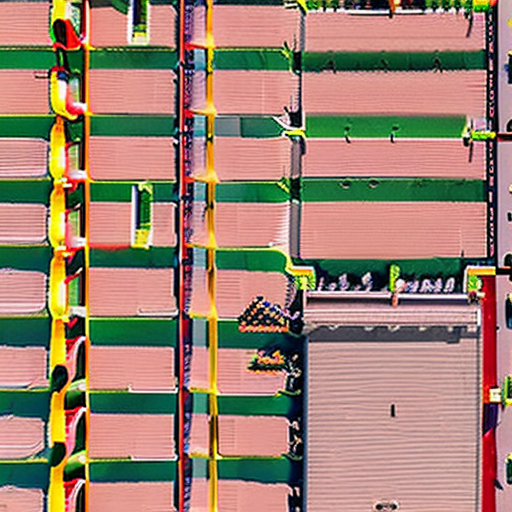

In [9]:
image = pipe1(caption, num_inference_steps=50, guidance_scale=7.5, height=512, width=512).images[0]
image

# Pipe: Finetuning with metadata, SNR 5

In [10]:
# If running on CPU (not recommended), then comment-out casting to float16 and the line which shifts the pipe to cuda

path = "E:\\grade_three_two\\diffusion_sat\\testdata\\finetune_sd21_sn-satlas-fmow_snr5_md7norm_bs64\\"
unet = SatUNet.from_pretrained(path + 'checkpoint-150000', subfolder="unet", torch_dtype=torch.float16)
pipe = DiffusionSatPipeline.from_pretrained(path, unet=unet, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

In [11]:
# caption = "a fmow satellite image of a amusement park in Australia"
# # Normalized metadata: [longitude, latitude, gsd, cloud cover, year, month, day]
# metadata = [ 925.8798,  345.2111, 411.4541,    0.0000,  308.3333,  166.6667, 354.8387]

# Or provide metadata values and then normalize
caption = "a fmow satellite image of a airport in hangzhou"
metadata = metadata_normalize([120.0746920, 30.3037577, 0.929417550564, 0.0765712666476, 2015, 2, 27]).tolist()

#### Prompt Pipe

Play around with guidance scale and number of inference steps to generate images

  0%|          | 0/20 [00:00<?, ?it/s]

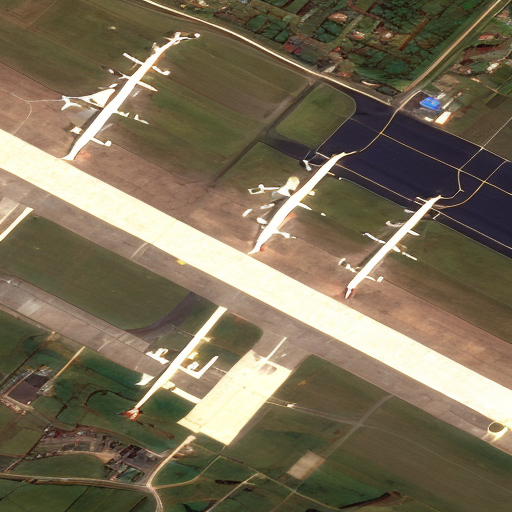

In [15]:
image = pipe(caption, metadata=metadata, num_inference_steps=20, guidance_scale=7.5, height=512, width=512).images[0]
image